# Calculate and save footprints over entire period.

* Intersect with a landscape classification map 


In [47]:
%matplotlib notebook
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from rasterio.plot import show

import matplotlib.pyplot as plt
import datetime
import Footprint_Processing as FP
import geopandas as gpd


try:
    os.mkdir('temp/')
except:
    pass

Output_Path = 'G:/My Drive/FishIsland_Outputs/'
RasterPath = Output_Path+'Footprints/'
DataName = 'FI_Data_2022-02-23.csv'
Data = pd.read_csv(Output_Path+DataName,parse_dates=['datetime'],index_col=['datetime'])
Data.head()

,DOY,file_records,used_records,Tau,qc_Tau,rand_err_Tau,H,qc_H,rand_err_H,LE,...,Delta_Table_1,Delta_VWC_1,Delta_VWC_2,fco2,fch4,Zm,Z0,Temp_15,Daytime,Sun_Angle
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-23 00:00:00-06:00,174,1800.0,1800.0,0.073630,0.0,NaN,6.368283,1.0,NaN,12.286230,...,NaN,NaN,0.000000e+00,-0.101038,0.023772,2.87,0.011457,NaN,1,8.449197
2017-06-23 00:30:00-06:00,174,1800.0,1800.0,0.074988,0.0,NaN,-17.662798,0.0,NaN,2.259226,...,NaN,NaN,0.000000e+00,0.561228,0.022941,2.87,0.008766,NaN,1,8.449197
2017-06-23 01:00:00-06:00,174,1800.0,1800.0,0.108962,0.0,NaN,-11.517344,0.0,NaN,1.372132,...,NaN,NaN,1.387779e-17,0.673105,0.025634,2.87,0.008251,NaN,1,5.502266
2017-06-23 01:30:00-06:00,174,1800.0,1800.0,0.084511,0.0,NaN,-9.591518,0.0,NaN,NaN,...,NaN,NaN,8.881688e-05,0.506380,0.025041,2.87,0.006339,NaN,1,5.502266
2017-06-23 02:00:00-06:00,174,1800.0,1800.0,0.070018,0.0,NaN,-8.110602,0.0,NaN,1.213447,...,NaN,NaN,1.657635e-04,0.490812,0.024376,2.87,0.006465,NaN,1,3.668524


# Date Range & Paramters

* Read & filter the data

In [49]:
DateRange=['2017-6-12 12:00:00','2017-9-14 23:30:00']
# DateRange=['2017-7-24 12:00:00','2017-7-24 20:30:00']  ## Subset for testing
Axis = 35
rs = [.1,.25,.5,.75,.8,.9,.95,.98]

Width = 2000#
dx = 2#
nx = int(Width/dx)

XY = [504679.13,7695885.39]
 
fp_params={'dx':dx,'nx':nx,'rs':rs}
thresh=.05

Run_Name=str(Width)+'mx'+str(dx)+'m'
    
Data['Run']=0
Data['Zm'] = 2.87
Data['Z_L'] = Data['Zm']/Data['L']

diff = []
Data['canopy_height'] = (Data['Canopy_Height_2']*.67+Data['Canopy_Height_1']*(.33))*.01
Data['canopy_height'] = Data['canopy_height'].bfill()
Data['Zo'] = Data['canopy_height']*.15
Data['d']=Data['canopy_height']*.66
Data['Zm']=Data['Zm']-Data['d']
Data['Z_L'] = Data['Zm']/Data['L']
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])
Data.loc[(Data['Z_L']<-thresh)|(Data['Z_L']>thresh),['Z0']]=np.nan
Data.loc[(Data['wind_speed']<1.5),['Z0']]=np.nan
diff.append(Data['Z0'].values.copy())
Daily = Data.resample('D').median()
Data['Ratio'] = Data['u*']/Data['wind_speed']
Wind_Groups_median = Data.groupby(['Dir']).median()
Wind_Groups_std = Data.groupby(['Dir']).std()
Wind_Groups_Ct = Data.groupby(['Dir']).count()
Wind_Groups_CI = Wind_Groups_std/Wind_Groups_Ct**.5*1.96

Wind_Groups_median['Dir'] = Wind_Groups_median.index*np.pi/180

Data.loc[(np.isfinite(Data['Zo'])==True)&(np.isfinite(Data['co2_flux'])==True)&
         (Data['u*']>.1)&
         (Data.index>DateRange[0])&
         (Data.index<DateRange[1])&              # Run a subset for teting
     ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
     ['Run']]=1

try:
    Data = Data.drop(['datetime'],axis=1)
except:pass
Run = Data.loc[Data['Run']==1].reset_index()
Runs = Run.shape[0]
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)
print(Transform)
print(west,north)
Data.shape

| 2.00, 0.00, 503679.13|
| 0.00,-2.00, 7696885.39|
| 0.00, 0.00, 1.00|
503679.13 7696885.39


(3962, 321)

## Footprints

[504679.13, 7695885.39]
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
Class    CollapsePolygonRim
Pct                     100
dtype: object


<IPython.core.display.Javascript object>


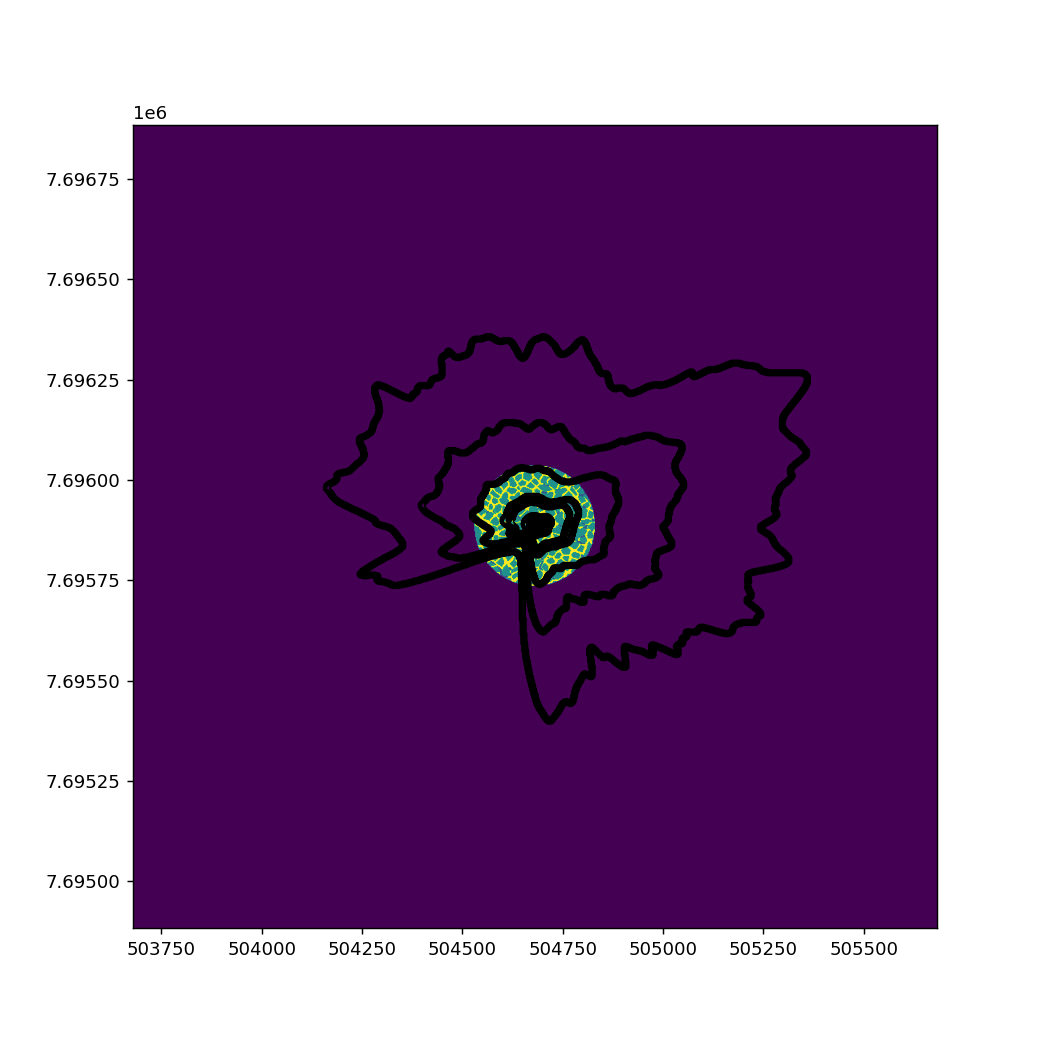

| 2.00, 0.00, 503679.13|
| 0.00,-2.00, 7696885.39|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(2.0, 0.0, 503679.13,
       0.0, -2.0, 7696885.39), 'tiled': False, 'interleave': 'band'}
2.0
   contour                                           geometry           area
0     0.10  POLYGON ((504685.130 7695891.390, 504685.139 7...     149.031568
1    

In [50]:
with rasterio.open('LC_Class'+str(dx)+'m.tif','w+',driver='GTiff',width = nx+1, height = nx+1,
                   count = 1,dtype=np.float64,transform = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    print(XY)
    print(params)
    bounds = (out.bounds)
from shapely.geometry import box
geom = box(*bounds)
df = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
df.to_file(Output_Path+'Classification/boundary.shp')

gdf = gpd.read_file(Output_Path+'/FI_FP_Landscape_Class.shp')
gdf['Class']=gdf['FIRST_Clas']
gdf['Pct'] = gdf['Shape_Area']/gdf['Shape_Area'].sum()*100
print(gdf[['Class','Pct']].sum())

fig,ax=plt.subplots(1,1,figsize = (8,8))
print(params['transform'])

LC = gdf
shapes = ((geom,value) for geom,value in zip(LC['geometry'],LC['Id']))
with rasterio.open('temp/LC_Class'+str(dx)+'m.tif','w+',**params) as out:
    out_arr = out.read(1)
    params = out.profile
    print(params)
    Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = Transform,default_value=0)
    print(Image)
    out.write(Image,1)

with rasterio.open('temp/LC_Class'+str(dx)+'m.tif','r') as Im:
    show(Im.read([1]),transform=Im.profile['transform'],ax=ax)
    Vals = Im.read(1)

Go = True
if Go == True:
    Domain = 'temp/LC_Class'+str(dx)+'m.tif'
    FP_Data = FP.Calculate(RasterPath,Run,Domain,XY,params,Classes=LC,ax=ax,
                           nx=nx,dx=dx,rs=rs,OtherClass='FarField',Name=Run_Name)
        
    Data = Data.merge(FP_Data.Intersections,left_on='datetime', right_on='datetime', how='outer')



In [51]:
File_Name = 'FI_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'_'+str(Width)+'m'+'x'+str(dx)+'m.csv'
Data.to_csv(Output_Path+File_Name)